In this notebook, I will demonstrate how to perform adaptive stitching and avoid cutting through freestanding parts. This is demonstrated on a microlensarray. 

In [2]:
%pylab

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import TipSlicer
import cv2
import scipy.ndimage as im
import tables
from importlib import reload
import os
import scipy.io
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
r_lenslet=150
samples = (1800,1800)
xgrng = np.array((-900, 900)) #in microns 
ygrng=xgrng
yg = np.linspace(ygrng[0], ygrng[1], samples[0])
xg=yg
px=xg[1] - xg[0]
py=px
X,Y= np.meshgrid(xg,yg)

In [8]:
file_best = '/home/kyrollos/randoscope/bestPrintSurface.mat'
file_best2 = '/home/kyrollos/randoscope/BestAndWorst/best_initPrint.mat'
loaded2 = scipy.io.loadmat(file_best2)
loaded = scipy.io.loadmat(file_best)
T=loaded['T']
xpos=loaded2['x_best']
ypos=loaded2['y_best']
rlist=loaded2['r_best']
Nlenslets=31
xpos=np.reshape(xpos,(31))*1000
ypos=np.reshape(ypos,(31))*1000
rlist=np.reshape(rlist,(31))*1000

In [31]:
def make_lenslet(Xlist, Ylist, Rlist, xg, yg, samples,r_lenslet,Nlenslets,aperR=900,height=50):
        T = np.zeros(len(xg))
        for n in range(Nlenslets):
            #sph = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-Rlist[n]+10
            sph1 = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-np.real(np.sqrt(0j+Rlist[n]**2-r_lenslet**2))

            T = np.maximum(T,sph1)
        aper = np.sqrt(xg**2+yg**2) <= aperR

        return (T)*aper


def make_lenslet_surf(z,Xlist, Ylist, Rlist, xg, yg, samples,r_lenslet,Nlenslets,aperR=900,height=0):
        if z<=height:
            aper=np.sqrt(xg**2+yg**2) <= aperR
            return aper.astype(float32)
        else:
            T = np.zeros(len(xg))
            for n in range(Nlenslets):
                #sph = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-Rlist[n]+10
                sph1 = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-np.real(np.sqrt(0j+Rlist[n]**2-r_lenslet**2))-(z-height)

                T = np.maximum(T,sph1)
                T=(T>0)
                T=T.astype(float32)
            aper = np.sqrt(xg**2+yg**2) <= aperR

            return (T)*aper




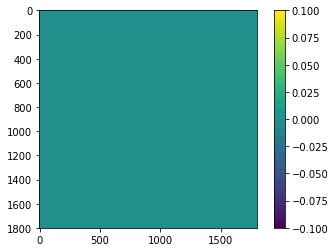

In [67]:
T=make_lenslet(xpos,ypos,rlist,X,Y,samples,r_lenslet,Nlenslets)
# rectangles = []
# dim1=len(T)
# dim2=dim1
# for m in range(dim1-1):
#     for n in range(dim2-1):
#             vertices = []
#             vertices.append( (m,n,T[m,n]))
#             vertices.append( (m+1,n,T[m+1,n]))
#             vertices.append( (m+1,n+1,T[m+1,n+1]))
#             vertices.append( (m,n+1,T[m,n+1]))
#             rectangles.append( vertices )
plt.imshow(T)
plt.colorbar()

1.0

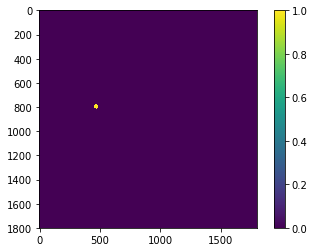

In [44]:
T2=make_lenslet_surf(53.5,xpos,ypos,rlist,X,Y,samples,r_lenslet,Nlenslets,height=50)
plt.imshow(T2)
plt.colorbar()
np.max(T2)

0.5539622562710065


-0.0

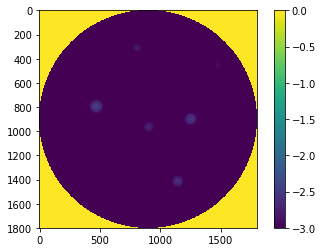

In [43]:
T2=make_lenslet_surf2(53,xpos,ypos,rlist,X,Y,samples,r_lenslet,Nlenslets,height=50)
plt.imshow(T2)
plt.colorbar()
np.max(T2)

In [111]:
def sliceFormula(X,Y,z,params):
    xpos,ypos,rlist,r_lenslet,height,aperR,indexPoint=params
    aper=np.sqrt(X**2+Y**2) <= aperR
    if z<=height:        
        return aper
    else:
        T = np.zeros(len(X))
        inds=range(len(xpos))
        if (indexPoint>-1):
            inds=[indexPoint]
        for n in inds:
            #sph = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-Rlist[n]+10
            sph1 = np.real(np.sqrt(0j+rlist[n]**2 - (X-xpos[n])**2 - (Y-ypos[n])**2))-np.real(np.sqrt(0j+rlist[n]**2-r_lenslet**2))-(z-height)
            T = np.maximum(T,sph1)
            T=(T>0)
        return (T)*aper
def sliceFormulaAber(X,Y,z,params):
    xpos,ypos,rlist,r_lenslet,height,aperR,indexPoint,Xn,Yn,aber=params
    
    aper=np.sqrt(X**2+Y**2) <= aperR
    Z=aber
    if z<=height:        
        return aper
    else:                         
        T = np.zeros(len(X))
        inds=range(len(xpos))
        if (indexPoint>-1):
            inds=[indexPoint]
        for n in inds:
            Xnzern=Xn- xpos[n]/np.max(X)
            Ynzern=Yn- ypos[n]/np.max(X)
            r = np.sqrt(np.square(Xnzern) + np.square(Ynzern))
            Z2  =  Z[n,0]  * 2.*Xnzern
            Z3  =  Z[n,1]  * 2.*Ynzern
            Z5  =  Z[n,2]  * 2.*np.sqrt(6.)*Xnzern*Ynzern
            Z6  =  Z[n,3]  * np.sqrt(6.)*(Xnzern**2-Ynzern**2)
            Z12 =  Z[n,4] * np.sqrt(10.)*(Xnzern**2-Ynzern**2)*(4*r**2-3)
            Z13 =  Z[n,5] * 2*np.sqrt(10.)*Xnzern*Ynzern*(4*r**2-3)
            Z23 =  Z[n,6] * 2*np.sqrt(14.)*Xnzern*Ynzern*(15*r**4-20*r**2+6)
            Z24 =  Z[n,7] * np.sqrt(14.)*(Xnzern**2-Ynzern**2)*(15*r**4-20*r**2+6)
            ZW = Z5+Z6+Z2+Z3+Z12+Z13+Z23+Z24
            #sph = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-Rlist[n]+10
            sph1 = ZW+np.real(np.sqrt(0j+rlist[n]**2 - (X-xpos[n])**2 - (Y-ypos[n])**2))-np.real(np.sqrt(0j+rlist[n]**2-r_lenslet**2))-(z-height)
            T = np.maximum(T,sph1)
            T=(T>0)
        return (T)*aper
    
r_lenslet=200
samples = (800,800)
xgrng = np.array((-1800, 1800)) #in microns 
ygrng=xgrng
yg = np.linspace(ygrng[0], ygrng[1], samples[0])
xg=yg
px=xg[1] - xg[0]
py=px
X,Y= np.meshgrid(xg,yg)

Xn =  X/np.max(X)
Yn =  Y/np.max(Y)

xpos=np.array([ 0.18578115,  0.74248238,  0.35555949,  0.10187365, -0.22157956,
       -0.5502,  0.29999206,  0.68421244,  0.11299734,  0.3125789 ,
        0.69618861, -0.28096646,  0.45888084, -0.27032854,  0.07697116,
       -0.5625567 , -0.58, -0.22702032,  0.07976543, -0.70372301,
       -0.34797056, -0.1152197 ,  0.41478314, -0.49736261,  0.39453689,
       -0.09447947, -0.08091086, -0.40003641,  0.04180626,  0.49347817,
        0.25394288,  0.02494959,  0.53552421,  0.28558491,  0.61067326,
       -0.72650046,-0.32])
ypos=np.array([-0.44942685,  0.0187904 , -0.08720638,  0.7031471 ,  0.11111811,
        0.2784 ,  0.16797938, -0.22899178, -0.07601691,  0.67472988,
        0.23505869,  0.65642641,  0.52935778,  0.36883709,  0.1762651 ,
        0.01505985, -0.4, -0.69954257,  0.41217862, -0.2266678 ,
       -0.06487182,  0.51443979, -0.30910161,  0.51766252, -0.53589769,
       -0.11244721, -0.46289246, -0.56147136, -0.29425527,  0.2757895 ,
       -0.69100594, -0.64317962,  0.01663745,  0.40540164, -0.42807524,
        0.168447,-0.3  ])
rlist=np.array([4.000442 , 4.440296 , 3.7237842, 3.5596673, 3.2063835, 5.4982405,
       4.2089086, 3.0839548, 5.3172565, 3.1439776, 6.364798 , 3.4829168,
       2.767    , 4.3215075, 4.839368 , 4.988825 , 2.8152227, 5.1478076,
       3.409406 , 6.9092703, 4.6986055, 3.2713168, 5.691979 , 4.5658   ,
       4.1020284, 2.970532 , 6.625868 , 7.218    , 3.8116512, 5.8998694,
       2.865156 , 3.6398768, 3.9037654, 2.9168925, 3.3389342, 3.026181 ,
       6.123522 ])

zernlist=np.array([[-1.17687108e-02,  5.72938053e-03,  4.86402947e-04,
          1.02568395e-03, -5.53892460e-04, -3.80602403e-04,
          2.16703731e-04, -1.65772639e-04],
        [ 9.18691512e-03, -1.41764516e-02,  1.23221905e-03,
          3.25909030e-04, -9.68211534e-05, -6.00047293e-04,
         -3.44769738e-04, -2.62714922e-04],
        [-1.52192945e-02,  6.26977906e-03,  4.31081513e-03,
          4.19008778e-03, -2.06371816e-03, -2.06740852e-03,
         -1.27902580e-03, -1.12184114e-03],
        [-9.34849901e-04,  7.38709001e-03,  5.65981679e-03,
          9.54413693e-03, -4.02503135e-03, -2.53599021e-03,
         -2.14189128e-03, -4.32867790e-03],
        [-1.20809732e-03,  2.84368359e-03,  8.09957646e-03,
          4.89915255e-03, -2.15096166e-03, -3.80802713e-03,
         -2.68443581e-03, -2.02441984e-03],
        [-5.75421983e-03,  3.12679261e-02,  2.75256205e-03,
         -7.10137412e-02,  3.46597955e-02, -8.41456582e-04,
         -1.69216830e-03,  2.52411831e-02],
        [-9.13037267e-03,  1.35897007e-02, -4.31771070e-04,
          9.50657122e-04, -4.85974335e-04,  1.82898977e-04,
          1.89318569e-04, -2.13005580e-04],
        [ 1.05885165e-02, -9.73359030e-03, -6.52839988e-03,
          1.07250856e-02, -5.43580437e-03,  3.13283387e-03,
          2.00536870e-03, -2.47683306e-03],
        [ 3.73808341e-03,  1.77262798e-02,  2.47818157e-02,
         -3.25277410e-02,  1.53422318e-02, -1.16963014e-02,
         -7.80709041e-03,  1.05514424e-02],
        [-8.48477893e-03,  1.33316685e-02, -2.63128127e-03,
         -1.82898138e-02,  8.77590571e-03,  1.07907213e-03,
          1.31903368e-03,  5.77957230e-03],
        [ 1.54856760e-02,  1.42496442e-02,  1.84594356e-02,
         -1.11813319e-03,  9.40047437e-04, -8.65375716e-03,
         -6.29085163e-03, -5.78843465e-04],
        [-3.03872563e-02,  2.16844771e-02, -1.46943622e-03,
         -4.22583194e-03,  2.07663304e-03,  7.20794022e-04,
          4.16112453e-04,  1.14025245e-03],
        [-8.90645012e-03,  1.80626512e-02,  2.15511234e-03,
         -2.26691714e-03,  1.05684542e-03, -1.57856673e-03,
          7.05824175e-04,  7.60983210e-04],
        [-1.83437613e-03,  3.10508739e-02, -6.50642114e-03,
         -6.55599264e-03,  3.03500216e-03,  3.19512258e-03,
          1.77449454e-03,  2.28093774e-03],
        [-4.89443075e-03,  1.71563178e-02,  1.12620299e-03,
         -5.08950278e-03,  2.43422389e-03, -5.52512472e-04,
         -3.04421730e-04,  1.51592458e-03],
        [-2.33156001e-03,  1.66538190e-02, -2.46943696e-03,
          6.26774691e-03, -2.85376911e-03,  1.41809962e-03,
          1.46982318e-04, -2.27591884e-03],
        [ 1.57451304e-03,  5.10710524e-03,  5.59779524e-04,
          1.80797512e-03, -1.23484351e-03, -2.80679320e-04,
         -1.42063654e-04,  3.66442458e-04],
        [ 1.30685670e-02, -1.55852530e-02,  2.09633051e-03,
          1.08887922e-04, -2.89632899e-05, -9.21230472e-04,
         -8.28909280e-04, -8.54352547e-05],
        [-2.13992898e-03,  4.51214658e-03,  3.77290393e-03,
         -7.96445354e-04,  6.25287823e-04, -1.71734497e-03,
         -1.35861780e-03, -3.55383294e-04],
        [-1.63696054e-02,  3.91316134e-03,  2.32828292e-03,
          2.13203346e-03, -7.43390003e-04, -8.81337619e-04,
         -1.29364710e-03, -1.35082367e-03],
        [ 2.38592364e-02,  1.72077138e-02, -2.44146995e-02,
         -2.16916651e-02,  9.80117358e-03,  1.15172407e-02,
          7.63633661e-03,  7.44849490e-03],
        [-1.38425101e-02,  2.01402456e-02,  1.84697434e-02,
          6.79916963e-02, -3.35409716e-02, -8.61542393e-03,
         -6.26588659e-03, -2.23558489e-02],
        [-1.55782634e-02,  2.75021754e-02, -3.79122756e-02,
         -3.95136606e-03,  6.19235914e-03,  2.67188679e-02,
          1.78853385e-02,  4.29455284e-03],
        [ 7.34934257e-03,  3.81172225e-02,  1.35775388e-03,
         -5.81855606e-03,  2.93009845e-03, -5.13883715e-04,
         -7.35414214e-04,  1.33206672e-03],
        [ 8.03712104e-03, -1.26246857e-02,  2.71372125e-03,
          1.86572745e-02, -8.73437896e-03, -8.67435243e-04,
         -1.89831364e-03, -6.13242015e-03],
        [-5.11535862e-03,  7.55936839e-03, -5.55838575e-04,
          4.80325107e-05, -2.07307658e-05,  3.46031389e-04,
         -3.19188475e-05, -1.97029785e-05],
        [-9.60495230e-03, -2.06307769e-02,  1.24520240e-02,
         -2.51650345e-03,  9.90037574e-04, -6.33014599e-03,
         -4.79466515e-03,  1.33734453e-03],
        [-2.72505172e-02, -1.20909624e-02, -2.25264672e-02,
         -2.40143575e-03,  1.16600783e-03,  1.09910490e-02,
          6.52287435e-03,  1.49576715e-03],
        [-1.72450929e-03,  6.24877168e-04,  1.36712345e-03,
          3.26830451e-03, -1.53485907e-03, -3.49324953e-04,
         -1.17910944e-03, -1.07539666e-03],
        [ 3.29686305e-03, -2.01407280e-02, -1.01621533e-02,
         -4.47628386e-02,  2.13928949e-02,  4.70676366e-03,
          3.43671581e-03,  1.45405391e-02],
        [ 7.59626157e-04, -8.80634133e-03, -6.26638625e-03,
         -2.34046089e-03,  1.43114186e-03,  3.05306795e-03,
          1.81378494e-03, -5.30399811e-05],
        [-3.57623049e-03, -6.27000816e-03,  3.30943568e-03,
          8.57026130e-03, -3.92703526e-03, -1.61554292e-03,
         -9.57676675e-04, -3.10674286e-03],
        [ 1.10184103e-02, -1.24534108e-02, -4.48538316e-03,
          2.43151851e-04, -1.40322576e-04,  2.08686176e-03,
          1.51283108e-03, -1.04431811e-05],
        [ 1.10035378e-03,  2.68782564e-02, -3.32446536e-03,
         -1.24092167e-02,  6.17399858e-03,  2.06362316e-03,
         -1.85530545e-04,  3.20189982e-03],
        [ 1.35034528e-02, -1.24763222e-02,  3.60997743e-03,
          9.84338205e-03, -5.09493193e-03, -1.44146360e-03,
         -1.81211857e-03, -2.04315945e-03],
        [-1.14218853e-02,  1.24582089e-02,  2.17783800e-03,
          9.41376842e-04, -7.77541951e-04, -9.71665955e-04,
         -8.56244063e-04,  5.27787488e-04],
        [-1.13196438e-02,  1.52079463e-02, -5.22434302e-02,
         -8.34508520e-03,  3.75179155e-03,  2.61506960e-02,
          1.68537926e-02,  2.93923542e-03]])

Nlenslets=37
xpos=np.reshape(xpos,(37))*1000
ypos=np.reshape(ypos,(37))*1000
rlist=np.reshape(rlist,(37))*1000
zernlist=zernlist*1000
height=50
aperR=900

7.237472914368027


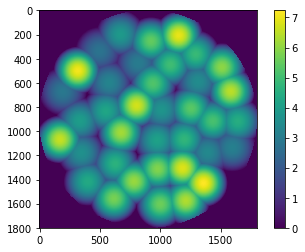

In [71]:
T=make_lenslet(xpos,ypos,rlist,X,Y,samples,r_lenslet,Nlenslets)
# rectangles = []
# dim1=len(T)
# dim2=dim1
# for m in range(dim1-1):
#     for n in range(dim2-1):
#             vertices = []
#             vertices.append( (m,n,T[m,n]))
#             vertices.append( (m+1,n,T[m+1,n]))
#             vertices.append( (m+1,n+1,T[m+1,n+1]))
#             vertices.append( (m,n+1,T[m,n+1]))
#             rectangles.append( vertices )
plt.imshow(T)
plt.colorbar()
print(np.max(T))

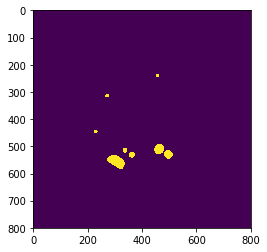

In [116]:

#plt.colorbar()

z=57
lens=-1  # putting this to a number between 0 and Nlenslets will show you what each block does
         # setting it to -1 will show all lenses..
clf()
#T=make_lenslet_surf(z,xpos,ypos,rlist,X,Y,samples,r_lenslet,Nlenslets)
#Back=sliceFormulaAber(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,-1,Xn,Yn,zernlist])
T=sliceFormulaAber(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,lens,Xn,Yn,zernlist])
#Mask=makeStitchingMask(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,lens,Xn,Yn,zernlist])
#Res=T*(Mask)
#Back=np.where(Back==0,NaN,Back)
#imshow(Back+Res)
imshow(T)
#plt.colorbar()
np.max(T)
z=z+0.2

54.5


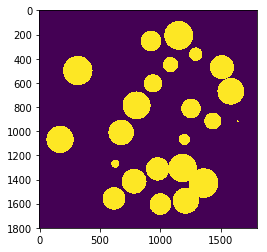

In [76]:
z=54.5
clf()
#T=make_lenslet_surf(z,xpos,ypos,rlist,X,Y,samples,r_lenslet,Nlenslets)
#Back=sliceFormulaAber(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,-1,Xn,Yn,zernlist])
T=sliceFormula(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,lens])
#Mask=makeStitchingMask(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,lens,Xn,Yn,zernlist])
#Res=T*(Mask)
#Back=np.where(Back==0,NaN,Back)
#imshow(Back+Res)
imshow(T)
print(z)
z=z+0.2

In [ ]:
# stlName='36lenslets_nanoscribe.stl'
# h5name='36_lenslets'
# [mm2,Zmins,Zmaxs]=loadStl(stlName,mulDimension=1.,centred=True,zToZero=True)
# stlToStack(mm2,h5name,X,Y,Z,Zmins,Zmaxs,inFillMaster='',writingMask=np.ones((1,1)),epsilon=0.001,onlyShell=False)

In [ ]:
optPoints=np.zeros((len(xpos),2))
for i in range (0,len(xpos)):
    optPoints[i,0]=xpos[i]
    optPoints[i,1]=ypos[i]

In [ ]:
# %%%time
# # now find optimal solution with CONCORDE and CPLEX
# TipSlicer.writeTSPfile('blocks.tsp',freePs)
# !concorde -o 'tsp.sol' 'blocks.tsp'
# Ord=TipSlicer.readTSPfile('tsp.sol')


In [ ]:
# clf()
# plot(freePs[Ord][:,0],freePs[Ord][:,1],'.-')

In [ ]:
# If you do not have concorde, try the nearest neighbour ordering
Ord,NNd=TipSlicer.TSPnearest(optPoints)


In [ ]:
pp=optPoints
pp_pix=TipSlicer.convertToPixels(X,Y,pp)

# Now write to GWL

In [ ]:
reload(TipSlicer)

In [ ]:
regions, vertices = TipSlicer.makeVoronoiPolygons(optPoints)

In [ ]:
#%%%time
# STEP 5: Write out stacks
#FovZ=55
FovZ=4
Fov=390
hatching=2
#slicing1=2
#slicing2=0.1
slicing=0.1
amShells=0
ScaffStep=1 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False
#CodeSpeeds=np.ones(3)*30000
#CodeIntensities=np.ones(3)*80


am=np.int(np.round(Fov/hatching))
#am=800
#amY=np.int(np.round(FovY/hatching))
zz1=np.arange(0,50,slicing1)
zz2=np.arange(50,55,slicing2)
#zz=np.concatenate((zz1,zz2))
zz=np.arange(0,FovZ,slicing)
dirName='StitchedMLARandoscope_Test15'
if (not os.path.exists(dirName)):
    os.mkdir(dirName)
genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
genRegex=dirName+'/.+gwl'
fullGwlName=dirName+'.gwl'
distList=[]




for i in np.arange(len(Ord)):
#for i in np.arange(5):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=optPoints[Ord[i],0]
    yc=optPoints[Ord[i],1]
    polygon = vertices[regions[Ord[i]]]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    MM=TipSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    # if you need overlap, do binary_dilation on the mask
    MM=im.binary_dilation(MM,iterations=3)
    #print(np.shape(xx))
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    TipSlicer.formulaToStack2(blockName,Xloc,Yloc,zz,make_lenslet_surf,xpos,ypos,rlist,Xloc,Yloc,samples,r_lenslet,Nlenslets,writingMask=MM)
    
    # and write the GWL's
    dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
                                   ,codeSpeeds=[50000,50000,50000],atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=False)
    try:
        distList.append(dists)
    except:
        print('Could not add dist to list',dists)
    
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)

In [ ]:
T=make_lenslet(xpos,ypos,rlist,X,Y,samples,r_lenslet,Nlenslets)
#test=T*MM.astype(float32)
plt.imshow(T)
plt.colorbar()
np.min(T)

In [ ]:
# #%%%time
# # STEP 5: Write out stacks
# FovZ=45
# Fov=300
# hatching=0.5
# slicing=3

# amShells=2
# ScaffStep=2 # for solid infill => 2*hatching is spacing here
# hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False


# am=np.int(np.round(Fov/hatching))
# #amY=np.int(np.round(FovY/hatching))
# zz=np.arange(0,FovZ,slicing)


# dirName='MicroLensArrayMiniscope'
# if (not os.path.exists(dirName)):
#     os.mkdir(dirName)
# genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
# genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
# genRegex=dirName+'/.+gwl'
# fullGwlName=dirName+'.gwl'

# #sliceIndList=np.arange(0,FovZ+slicing,slicing)

# #print(len(sliceIndList))
# #print(sliceIndList)
# #print(zz[sliceIndList])

# fullDist=[]
# allBlocks=[]
# for i in np.arange(0,len(Ord)):
# #for i in np.arange(0,10):
#     # now make coordinate systems
#     print('Writing block {}'.format(i))
#     xc=freePs[Ord][i,0]
#     yc=freePs[Ord][i,1]

#     xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
#     yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
#     Xloc,Yloc=np.meshgrid(xx,yy)
    
#     # make the writing mask
#     seeds=TipSlicer.convertToPixels(Xloc,Yloc,freeLabPos[Ord[i]])
#     Tloc=myFigure(Xloc,Yloc,0,0)
#     MM=TipSlicer.makeFreeMaterialMatrix(Tloc,seeds)
    
# #    MM=FormulaSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    
    
#     # with these coordinate systems, apply formulaToStack
#     blockName=genBlockName.format(i)
    
#     TipSlicer.formulaToStack(blockName,Xloc,Yloc,zz,myFigure,extraParams=0,writingMask=MM)
#     allBlocks.append(blockName)
#     # and write the GWL's
#     #print(sliceIndList)
#     dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
#                                    ,atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=True)
#     if (len(dists)>0):
#         if (len(fullDist)==0):
#             fullDist=dists
#         else:
#             fullDist=fullDist+dists

    
# TipSlicer.writeGwlForRegex(fullGwlName,genRegex)

# #writeTime=(fullDist/CodeSpeeds[:len(fullDist)]).sum()/3600.
# #print('Printing will take +- {:.2f} hours'.format(writeTime))

In [ ]:
CodeSpeeds=np.array([30000,30000,30000])
writeTime=(fullDist/CodeSpeeds[:len(fullDist)]).sum()/3600.
print('Printing will take +- {:.2f} hours'.format(writeTime))

# Now do hexagonal tiling

In [ ]:
hexPos=TipSlicer.getHexStitchCentres(T,150,X,Y)
print(len(hexPos))

In [ ]:
# STEP 4: Make voronoi tesselation
regions, vertices = TipSlicer.makeVoronoiPolygons(hexPos)
#ffOpt=FormulaSlicer.getInfillRatio(regions,vertices,T,X,Y)

# and display it
clf()
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.6)

plt.plot(hexPos[:,0], hexPos[:,1], 'ko')
plt.axis('equal')
#plt.xlim(vor.min_bound[0] - 20, vor.max_bound[0] + 20)
#plt.ylim(vor.min_bound[1] - 20, vor.max_bound[1] + 20)

plt.imshow(T,alpha=0.8,extent=(X.min(),X.max(),Y.max(),Y.min()))
display(gcf())

In [ ]:
%%%time
# now find optimal solution with CONCORDE and CPLEX
pp=hexPos
TipSlicer.writeTSPfile('blocks.tsp',pp)
!concorde -o 'tsp.sol' 'blocks.tsp'
Ord=TipSlicer.readTSPfile('tsp.sol')

In [ ]:
#%%%time
# STEP 5: Write out stacks
FovZ=45
Fov=300
hatching=0.5
slicing=3

amShells=2
ScaffStep=2 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False
#CodeSpeeds=np.ones(3)*30000
#CodeIntensities=np.ones(3)*80


am=np.int(np.round(Fov/hatching))
#amY=np.int(np.round(FovY/hatching))
zz=np.arange(0,FovZ,slicing)


dirName='MicroLensesHexagonal'
if (not os.path.exists(dirName)):
    os.mkdir(dirName)
genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
genRegex=dirName+'/.+gwl'
fullGwlName=dirName+'.gwl'

for i in np.arange(len(Ord)):
#for i in np.arange(10):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=hexPos[Ord[i],0]
    yc=hexPos[Ord[i],1]
    polygon = vertices[regions[Ord[i]]]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    MM=TipSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    # if you need overlap, do binary_dilation on the mask
    MM=im.binary_dilation(MM,iterations=2)
    
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    # make a formula for formulaToStack for SERPENTIN!!!
    TipSlicer.formulaToStack(blockName,Xloc,Yloc,zz,myFigure,extraParams=0,writingMask=MM)
    
    # and write the GWL's
    dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
                                   ,atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=True)
    
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)#,CodeSpeeds,CodeIntensities)